In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s05/"
#PROFILE = "sineasy10-3x128-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "1"
config["DEVICE"] = "cpu"
config["RERUNS"] = "1"
config["HIDDEN_FEATURES"] = "[]"
config["GUIDE_SCALE"] = "0.001"


config["LIKELIHOOD_SCALE_LOC"] = "1.0"
config["OBS_MODEL"] = "homoskedastic_gamma"
config["LIKELIHOOD_SCALE"] = "1.0"



dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["SIGMA"] = "0.8"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -3.3443794483513587 - 3.057224599555369
In Domain: (-10, 10)
Y-space: -3.076650198826965 - 2.8018772258827322
Out Domain: (-20, 20)
Y-space: -2.5940238150635797 - 3.4086463668516838


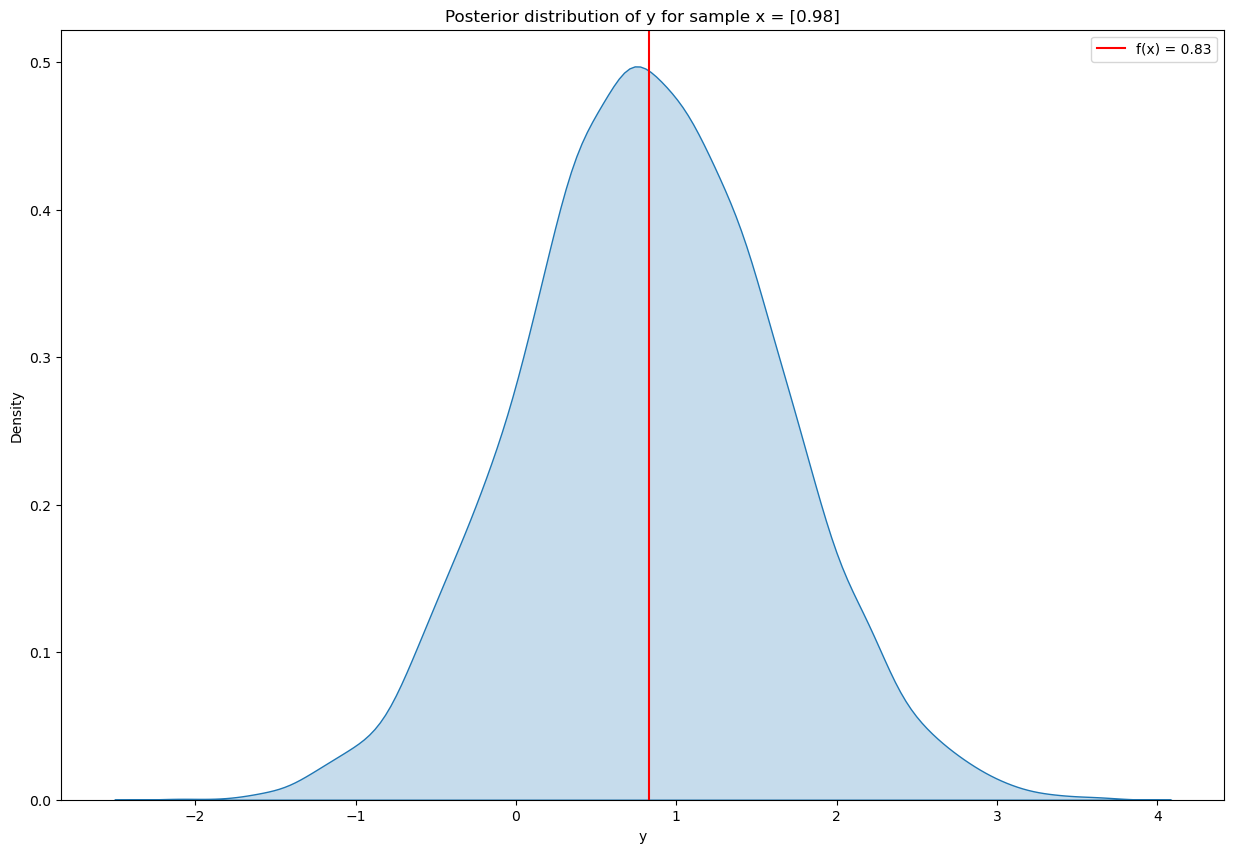

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


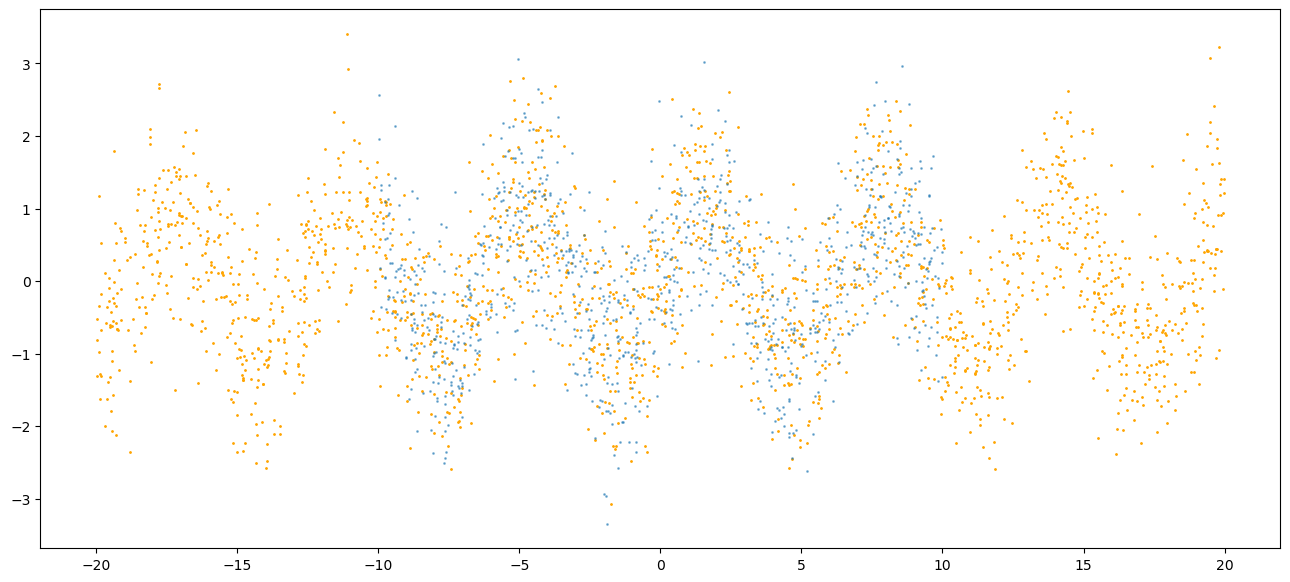

In [8]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
    plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

Cuda Devices: []
torch.Size([128, 1]) torch.Size([128, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
Using device: cpu
===== Training profile tyxe-test - 1 =====
preds tensor([[[-2.2523],
         [ 1.2118],
         [-4.5768],
         ...,
         [-1.1786],
         [-3.0826],
         [ 2.7395]],

        [[ 2.7300],
         [ 5.5931],
         [-1.7061],
         ...,
         [ 1.0483],
         [-0.3493],
         [ 2.3845]],

        [[ 1.7868],
         [ 0.3658],
         [-0.2132],
         ...,
         [-3.6761],
         [-8.3169],
         [ 2.8634]],

        ...,

        [[-2.0566],
         [-2.8560],
         [-5.7454],
         ...,
         [ 0.1488],
         [ 1.6954],
         [ 4.3695]],

        [[ 5.6364],
         [ 1.4989],
         [-5.0300],
         ...,
         [-2.7629],
         [-1.5956],
         [ 3.

In [10]:
params = pyro.get_param_store()
params.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale'])

In [11]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
preds tensor([[[-8.1760e-01]],

        [[-5.5081e-01]],

        [[-8.1601e-01]],

        [[-4.1007e-01]],

        [[-9.1601e-02]],

        [[ 1.0840e+00]],

        [[-1.2770e-01]],

        [[ 2.3036e+00]],

        [[ 3.1516e-01]],

        [[ 7.4811e-01]],

        [[ 7.1651e-01]],

        [[ 1.4897e+00]],

        [[-2.4019e-01]],

        [[ 2.1704e+00]],

        [[ 5.5174e-01]],

        [[-1.6336e+00]],

        [[-3.9423e-01]],

        [[ 1.1394e+00]],

        [[ 8.9546e-01]],

        [[-3.5236e-01]],

        [[ 2.2758e+00]],

        [[-1.7965e-01]],

        [[-2.3747e+00]],

        [[ 8.2129e-01]],

        [[-2.5826e+00]],

        [[-3.6197e-01]],

        [[ 1.9635e+00]],

        [[ 1.0646e+00]],

        [[-4.6860e-01]],

        [[-1.3222e+00]],

        [[ 1.8917e+00]],


In [12]:
preds2 = bnn.predict(x_test, num_predictions=100, aggregate=False)

preds tensor([[[-3.1116],
         [-3.5212],
         [-0.6672],
         ...,
         [ 1.1478],
         [ 1.1539],
         [ 0.2048]],

        [[-3.8210],
         [-1.4822],
         [-1.8411],
         ...,
         [-1.7227],
         [ 0.9463],
         [-1.1715]],

        [[ 2.7767],
         [-0.3961],
         [ 1.0863],
         ...,
         [ 1.6911],
         [-3.6373],
         [-0.6707]],

        ...,

        [[-0.1535],
         [ 0.9184],
         [-1.8759],
         ...,
         [-0.1126],
         [ 3.0965],
         [-1.4912]],

        [[ 0.1192],
         [ 2.3086],
         [-0.6072],
         ...,
         [ 1.1806],
         [-0.6288],
         [-1.0138]],

        [[-0.3891],
         [ 0.7249],
         [-0.8462],
         ...,
         [-1.9699],
         [ 0.8318],
         [-1.7100]]])
mean tensor([[-0.4344],
        [-0.1683],
        [-0.1263],
        ...,
        [-0.2374],
        [ 0.2061],
        [ 0.0380]])
std tensor([[1.6314],
        [

In [13]:
dummy_input = torch.randn(1, 1)
weights = bnn.get_weight_distributions()
weights.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale'])

In [14]:
#collect all weights in a list
weight_scale_list = []
for name, data in weights.items():
    if "scale" in name:
        print(name, data.reshape(-1).shape)
        weight_scale_list.append(data.reshape(-1))
weight_scale_list = torch.cat(weight_scale_list)
weight_scale_list.mean()




net_guide.net.0.weight.scale torch.Size([1])
net_guide.net.0.bias.scale torch.Size([1])
likelihood_guide.likelihood._scale.loc torch.Size([1])
likelihood_guide.likelihood._scale.scale torch.Size([1])


tensor(0.1229, grad_fn=<MeanBackward0>)

In [15]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=False)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

preds tensor([[[-2.0446],
         [-0.4312],
         [ 0.4934],
         ...,
         [ 1.1718],
         [-1.3825],
         [-1.5737]],

        [[-3.4783],
         [-0.9914],
         [-1.2878],
         ...,
         [ 0.7334],
         [ 1.9373],
         [ 0.6638]],

        [[ 0.9369],
         [-1.5173],
         [-1.3904],
         ...,
         [-0.5560],
         [ 0.7453],
         [-0.1574]],

        ...,

        [[-0.3078],
         [ 0.7190],
         [ 0.2164],
         ...,
         [ 1.2193],
         [-0.3434],
         [ 1.9407]],

        [[-3.5020],
         [-0.6403],
         [-1.4044],
         ...,
         [-0.1265],
         [-1.9346],
         [-1.9521]],

        [[ 1.4671],
         [ 2.8976],
         [ 0.0788],
         ...,
         [ 3.4356],
         [-1.5185],
         [-2.0168]]])
mean tensor([[-0.4332],
        [-0.4905],
        [-0.4512],
        ...,
        [ 0.4282],
        [ 0.4654],
        [ 0.5024]])
std tensor([[1.4753],
        [

In [16]:
means

tensor([[-0.4332],
        [-0.4905],
        [-0.4512],
        ...,
        [ 0.4282],
        [ 0.4654],
        [ 0.5024]])

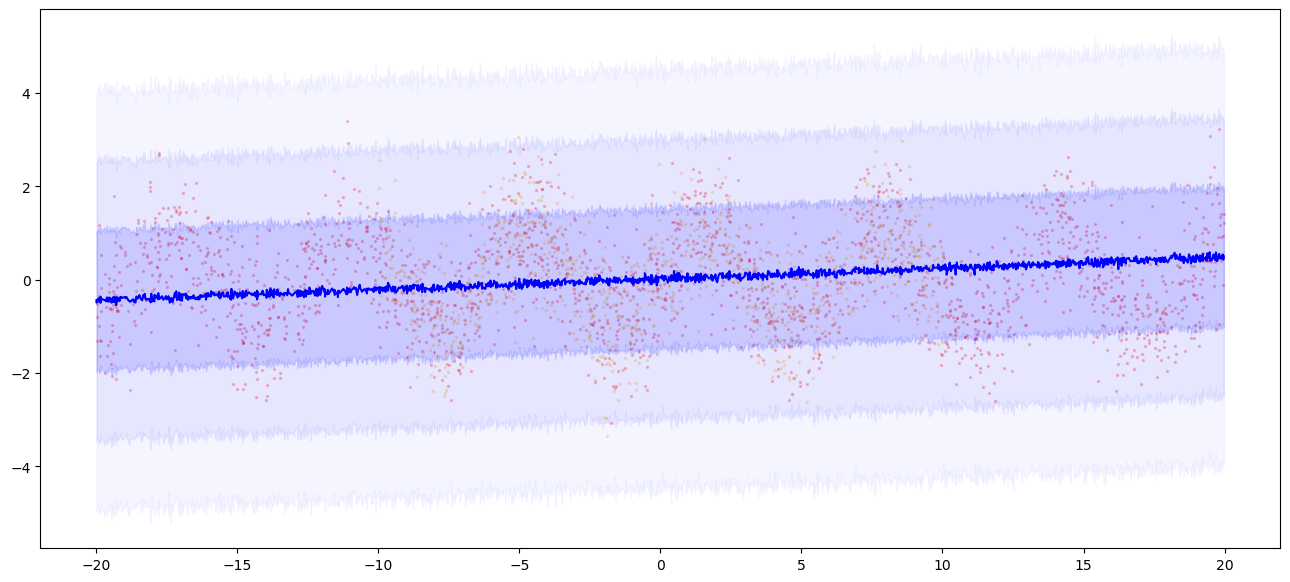

In [17]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    plt.plot(x_test[test_sort], means, color="blue")
    #plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
    for c in range(1, 4):
        plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

preds tensor([[[-1.3354],
         [ 2.4478],
         [-0.6152],
         ...,
         [-1.0937],
         [ 2.3639],
         [ 2.0876]],

        [[-0.3500],
         [-2.4089],
         [-0.7142],
         ...,
         [ 0.9510],
         [-0.2661],
         [ 1.8699]],

        [[-1.0185],
         [ 0.2017],
         [ 1.7692],
         ...,
         [ 1.0717],
         [ 1.0617],
         [-0.1359]],

        ...,

        [[ 0.3951],
         [-1.0703],
         [-1.4973],
         ...,
         [ 0.4084],
         [ 3.6459],
         [-0.6998]],

        [[-1.3183],
         [ 0.2446],
         [ 0.4625],
         ...,
         [ 0.8516],
         [-0.1047],
         [ 1.9626]],

        [[-2.8267],
         [-2.4912],
         [ 0.0284],
         ...,
         [-0.9286],
         [ 0.4343],
         [-0.3207]]])
mean tensor([[-0.4412],
        [-0.5844],
        [-0.4753],
        ...,
        [ 0.6444],
        [ 0.5728],
        [ 0.4917]])
std tensor([[1.2808],
        [

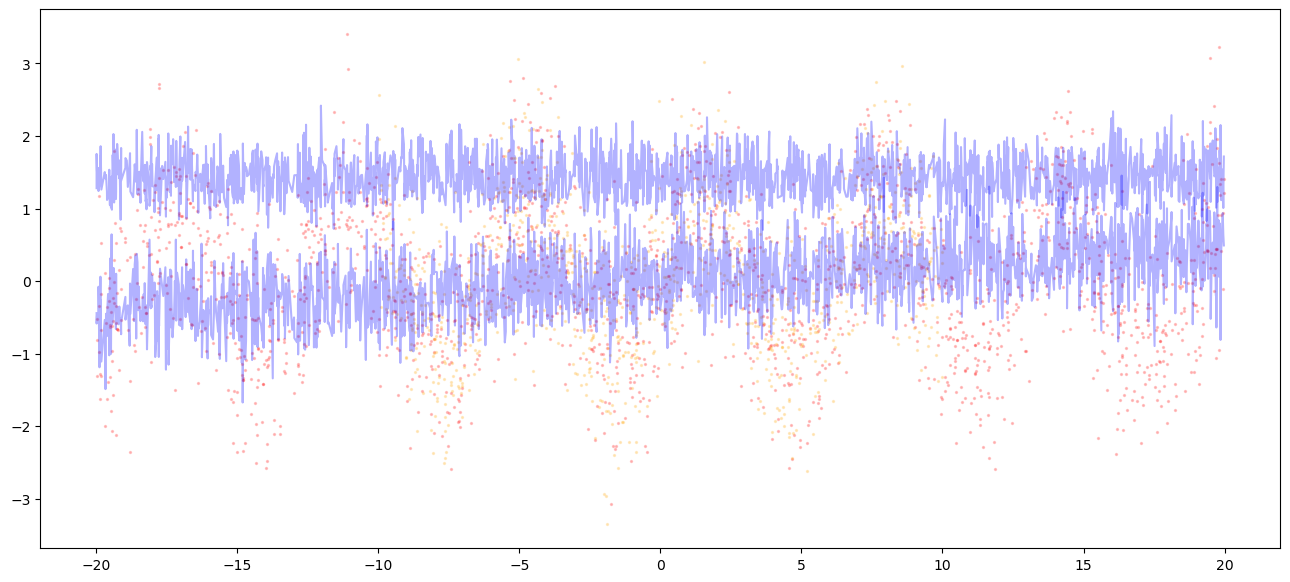

In [18]:
if dataset_config["X_DIM"] == "1":
    sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=15, aggregate=False)
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    for yhat in sampled_predictions:
        plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [19]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None, reruns=config.getint("RERUNS"))

data samples:  (1000, 1000)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
preds tensor([[[ 5.5359e-02]],

        [[-3.9418e+00]],

        [[-7.6543e-01]],

        [[ 3.6257e+00]],

        [[-3.2027e-01]],

        [[-1.9476e+00]],

        [[-4.8479e-01]],

        [[-9.1438e-01]],

        [[-1.1027e+00]],

        [[ 6.4571e-01]],

        [[ 5.2926e-01]],

        [[ 6.6308e-01]],

        [[ 2.2872e+00]],

        [[ 2.1099e+00]],

        [[-1.3838e+00]],

        [[ 1.0278e+00]],

        [[-1.8705e-01]],

        [[ 6.5353e-01]],

        [[ 8.5300e-01]],

        [[ 1.8659e+00]],

        [[-1.6399e+00]],

        [[ 5.4516e-01]],

        [[ 4.2303e-01]],

        [[ 4.7226e-01]],

        [[ 8.3750e-01]],

        [[-9.8990e-01]],

        [[-3.1102e+00]],

        [[ 4.6730e-02]],

        [[ 3.5794e-01]],

        [[-9.9630e-01]]

In [20]:
profiles= [PROFILE]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [21]:
from IPython.display import display, HTML

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [22]:
train_stats

{'tyxe-test': {'elbos': [275.10658073425293,
   273.13053703308105,
   273.5968589782715,
   272.14463233947754,
   268.1092071533203,
   266.1736640930176,
   264.3749580383301,
   260.4853324890137,
   263.5347709655762,
   262.85866928100586,
   263.30220222473145,
   254.8042278289795,
   259.7828845977783,
   266.2080078125,
   259.0969715118408,
   256.91967964172363,
   256.6821994781494,
   253.35617637634277,
   251.81610298156738,
   259.7159481048584,
   248.00870895385742,
   252.55473136901855,
   251.00683975219727,
   248.87536811828613,
   251.62414932250977,
   249.4672336578369,
   247.41077613830566,
   239.53630256652832,
   243.0799446105957,
   246.44257354736328,
   241.23931884765625,
   237.09094619750977,
   239.47398948669434,
   237.4027500152588,
   238.0681610107422,
   241.58313941955566,
   234.07502555847168,
   238.66464042663574,
   234.1896800994873,
   235.57758140563965,
   236.2686653137207,
   231.56089782714844,
   232.16791915893555,
   238.024

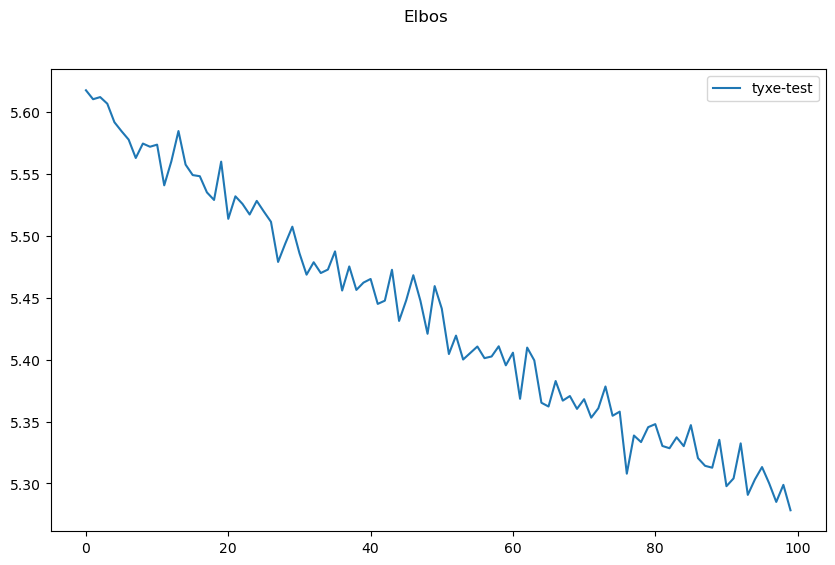

In [23]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Elbos")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["elbos"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("MSE loss")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["loss"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()


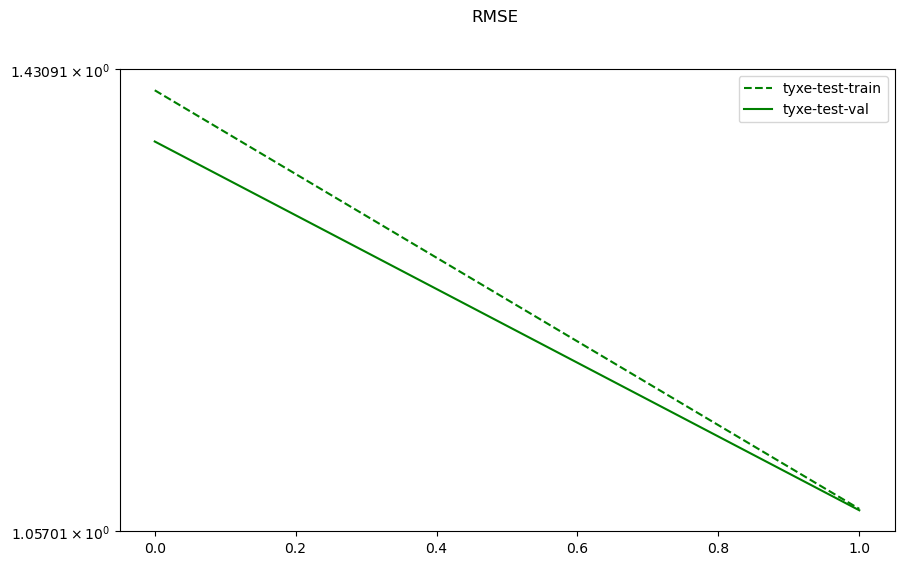

In [24]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("RMSE")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        te = train_stats[name]["train_rmse"]
        ax.plot(te, '--', label=f"{name}-train", color=colors[i])
        ve = train_stats[name]["val_rmse"]
        ax.plot(ve, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', base=10)
    ax.legend()
    plt.show()

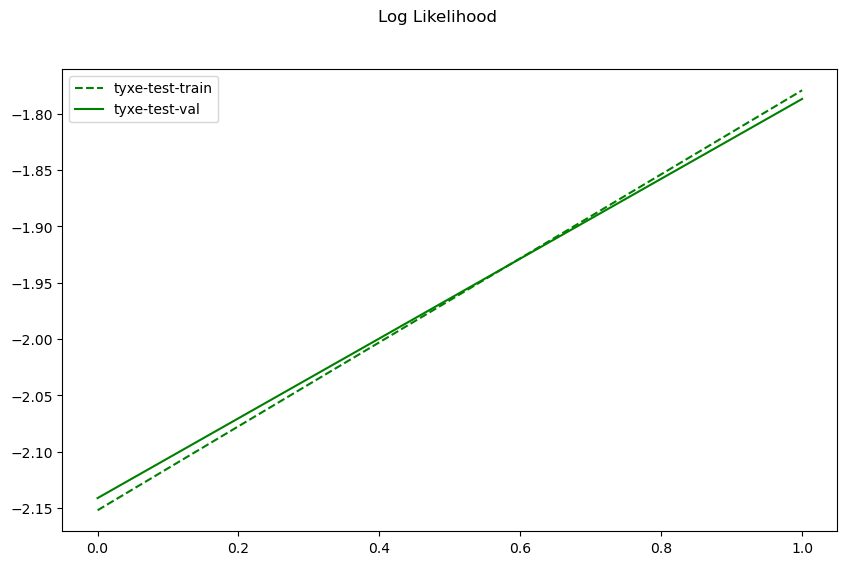

In [25]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Log Likelihood")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        tll = train_stats[name]["train_ll"]
        ax.plot(tll, '--', label=f"{name}-train", color=colors[i])
        vll = train_stats[name]["val_ll"]
        ax.plot(vll, label=f"{name}-val", color=colors[i])
    ax.legend()
    plt.show()

In [26]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}

In [27]:
trace = poutine.trace(bnn.guide, param_only=True).get_trace(torch.ones(1, 1))
for name, value in trace.nodes.items():
    print(name, value["value"])

net_guide.net.0.weight.loc Parameter containing:
tensor([[0.0230]], requires_grad=True)
net_guide.net.0.weight.scale tensor([[0.0016]], grad_fn=<AddBackward0>)
net_guide.net.0.bias.loc Parameter containing:
tensor([0.0172], requires_grad=True)
net_guide.net.0.bias.scale tensor([0.0016], grad_fn=<AddBackward0>)
likelihood_guide.likelihood._scale.loc Parameter containing:
tensor(0.3897, requires_grad=True)
likelihood_guide.likelihood._scale.scale tensor(0.0987, grad_fn=<AddBackward0>)


In [28]:
preds = bnn.predict(x_train, num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

preds tensor([[[-0.8665],
         [-1.5770],
         [-0.1903],
         ...,
         [ 0.4139],
         [ 1.3097],
         [-2.1942]],

        [[ 0.1065],
         [ 0.3550],
         [ 2.4664],
         ...,
         [ 0.1876],
         [-0.8306],
         [-0.6183]],

        [[-2.3925],
         [ 3.9144],
         [-1.4323],
         ...,
         [ 0.4970],
         [-0.2824],
         [-0.5169]],

        ...,

        [[ 0.3910],
         [-1.7262],
         [-2.2389],
         ...,
         [-3.5536],
         [-0.6189],
         [-0.9437]],

        [[ 1.6200],
         [-1.9166],
         [-1.2228],
         ...,
         [-2.0147],
         [-4.4431],
         [ 0.7295]],

        [[ 0.1016],
         [-1.4311],
         [ 1.6361],
         ...,
         [ 0.2438],
         [ 0.8076],
         [ 1.3898]]])
mean tensor([[ 7.2028e-03],
        [ 1.4294e-01],
        [ 8.0273e-02],
        [-4.9508e-02],
        [-4.6692e-02],
        [ 1.7944e-01],
        [-9.1085e-02]